# RESOLUÇÃO DE PROBLEMA APLICADO

Autora: Racquel Knust

Disciplina: Metamateriais Acústicos

Bimestre: 2º/2024

## Bibliotecas

In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd

## Funções

In [2]:
def calc_coiledspaces_density(
    omega: np.array,
    rho0: float,
    eta: float,
    a: float,
    b: float
):

  nu = eta/rho0
  inner=0
  for k in range(200):
    for n in range(200):
      alpha_k = (np.pi/a)*(k+(1/2))
      beta_n = (np.pi/b)*(n+(1/2))
      inner += ((alpha_k**2)*(beta_n**2)*((alpha_k**2)+(beta_n**2)+(1j*(omega/nu))))**(-1)
  rho_eq = rho0*((nu*(a**2)*(b**2))/(4*1j*omega))*(inner**(-1))

  return rho_eq

In [3]:
def calc_coiledspaces_compressibility(
    omega: np.array,
    P0: float,
    gamma: float,
    a: float,
    b: float,
    kappa: float,
    rho0: float,
    Cv: float
):

  nu_linha = kappa/(rho0*Cv)
  inner = 0
  for k in range(200):
    for n in range(200):
      alpha_k = (np.pi/a)*(k+(1/2))
      beta_n = (np.pi/b)*(n+(1/2))
      inner += ((alpha_k**2)*(beta_n**2)*((alpha_k**2)+(beta_n**2)+(1j*((omega*gamma)/nu_linha))))**(-1)
  C_eq = (1/P0)*(1-(((4*1j*omega*(gamma-1))/(nu_linha*(a**2)*(b**2)))*inner))

  return C_eq

In [4]:
def calc_coiledspaces_impedance(
    omega: np.array,
    m: float,
    b:float,
    h: float,
    N: int,
    L: float,
    rho0: float,
    eta: float,
    P0: float,
    gamma: float,
    kappa: float,
    Cv: float
):

  a = m - b
  W = (h - ((N-1)*b))/N

  So = m*L
  Si = a*W
  epsilon = So/Si

  Leff = N*np.sqrt(((W)**2)+((L-b)**2))

  rho_ef = calc_coiledspaces_density(omega, rho0, eta, a, W)
  C_ef = calc_coiledspaces_compressibility(omega, P0, gamma, a, W, kappa, rho0, Cv)

  Z_cs = -1j*epsilon*np.sqrt(rho_ef/C_ef)*(1/np.tan(omega*np.sqrt(rho_ef*C_ef)*Leff))

  return Z_cs

In [5]:
def calc_painel_impedance(
    omega: np.array,
    rho0: float,
    df: float,
    Lf: float,
    m: float,
    L: float,
    eta: float,
    t: float
):
  Theta = (df*Lf)/(m*L)

  sigmas = df*np.sqrt((rho0*omega)/(4*eta))

  epsilon = df/L
  Fok = (1-(1.4092*epsilon)+(0.33818*(epsilon**3))+(0.06793*(epsilon**5))-(0.02287*(epsilon**6))+(0.03015*(epsilon**7))-(0.01641*(epsilon**8)))**(-1)

  e = np.sqrt(1-((df/(2*Lf))**2))
  def Fe_func(x):
    return 1/np.sqrt(1-((e**2)*(np.sin(x)**2)))
  Fe, _ = quad(Fe_func, 0, np.pi/2)

  Z_p = (((1j*omega*rho0*t)/Theta)*((1-(np.tanh(sigmas*np.sqrt(1j))/(sigmas*np.sqrt(1j))))**(-1)))
  Z_p += (np.sqrt(2*rho0*eta*omega))/(2*Theta)
  Z_p += 1j*omega*rho0*((df*Fe*Fok)/(2*Theta))

  return Z_p


In [6]:
def calc_porousmedium_impedance(
    omega: np.array,
    rho0: float,
    alphainf: float,
    sigma: float,
    phi: float,
    eta: float,
    Lambda: float,
    Lambdalinha: float,
    gamma: float,
    P0: float,
    Pr: float,
    e: float,
):

  rho_ef = ((rho0*alphainf))*(1+(((sigma*phi)/(1j*omega*rho0*alphainf))*np.sqrt(1+(1j*((4*eta*omega*rho0*(alphainf**2))/((sigma**2)*(Lambda**2)*(phi**2)))))))

  K_ef = (gamma*P0)/(gamma - ((gamma-1)*((1+(((8*eta)/(1j*omega*Pr*rho0*(Lambdalinha**2)))*np.sqrt(1+((1j*omega*Pr*rho0*(Lambdalinha**2))/(16*eta)))))**(-1))))

  cf = np.sqrt(rho_ef/K_ef)

  Z_f = -1j*(np.sqrt(rho_ef*K_ef)/phi)*(1/np.tan((omega*e)*cf))

  return Z_f

In [27]:
def calc_finalimpedance(
    f: np.array,
    m: float,
    b:float,
    h: float,
    N: int,
    L: float,
    rho0: float,
    eta: float,
    P0: float,
    gamma: float,
    kappa: float,
    Cv: float,
    df: float,
    Lf: float,
    t: float,
    alphainf: float,
    sigma: float,
    phi: float,
    Lambda: float,
    Lambdalinha: float,
    Pr: float,
    e: float,
):

  omega = 2*np.pi*f

  Z_p = calc_painel_impedance(
      omega,
      rho0,
      df,
      Lf,
      m,
      L,
      eta,
      t
  )

  Z_cs = calc_coiledspaces_impedance(
      omega,
      m,
      b,
      h,
      N,
      L,
      rho0,
      eta,
      P0,
      gamma,
      kappa,
      Cv
  )

  Z_s = Z_p + Z_cs

  Z_f = calc_porousmedium_impedance(
      omega,
      rho0,
      alphainf,
      sigma,
      phi,
      eta,
      Lambda,
      Lambdalinha,
      gamma,
      P0,
      Pr,
      e,
  )

  Z_hybrid = ((1/Z_f)+(1/Z_s))**(-1)

  Z_nohybrid = Z_s

  return Z_hybrid, Z_nohybrid

In [8]:
def calc_absorptioncoefficient(
    Z_final: np.array,
    Z0: float
):

  alpha = 1 - (np.abs(((Z_final/Z0) - 1)/((Z_final/Z0) + 1))**2)

  return alpha

In [9]:
def calc_indicators(
    alpha: np.array,
    f: np.array,
    c0: float,
    h: float
):
  max_value = np.max(alpha)

  index_max_value = np.argmax(alpha)
  freq_max_value = f[index_max_value]

  half_max_value = max_value*0.5
  indices_half_max = np.where(np.isclose(alpha*100, half_max_value*100, atol=5e-1))[0]
  if len(indices_half_max) >= 2:
      freq_half_max_1 = f[indices_half_max[0]]
      freq_half_max_2 = f[indices_half_max[-1]]
      deltaf50 = freq_half_max_2 - freq_half_max_1
      deltaf50_rel = deltaf50/freq_max_value
      if deltaf50 <= 5:
          freq_half_max_2 = None
          deltaf50 = None
          deltaf50_rel = None
  else:
      freq_half_max_1, freq_half_max_2, deltaf50, deltaf50_rel = None, None, None, None

  E = h/(c0/freq_max_value)

  E_inv = 1/E

  return max_value, freq_max_value, freq_half_max_1, freq_half_max_2, deltaf50, deltaf50_rel, E, E_inv

## Definições de Parâmetros

In [10]:
## Parâmetros dos Espaços Enrolados - Perfuração: Fenda
N = 3 #Número de Espaços Enrolados
Lf = 6e-3 #Largura da Fenda
df = 0.358e-3 #Altura da Fenda
t = 2.7e-3 #Espessura do Painel
h = 22e-3 #Espessura da Cavidade
b = 1.25e-3 #Espessura das Paredes
L = 30e-3 #Altura da Célula Unitária
m = 13e-3 #Largura da Célula Unitária

In [11]:
## Parâmetros do Fluido (Ar)
P0 = 101325. #Pressão Atmosférica
rho0 = 1.21 #Densidade do Ar
c0 = 343. #Velocidade do Som no Ar
gamma = 1.40 #Razão entre Capacidades Térmicas
eta = 1.8134e-5 #Viscosidade Dinâmica do Ar
Pr = 0.71 #Número de Prandtl do Ar
kappa = 0.026 #Condutividade Térmica
Cv = 712.05 #Calor Específico a Volume Constante
Cp = 1007.16 #Calor Específico a Pressão Constante

In [12]:
## Parâmetros do Material Poroso (Lã de Vidro)
sigma = 127023 #Resisitividade ao fluxo
phi = 0.98 #Porosidade
alphainf = 1.19 #Tortuosidade
Lambda = 10e-6 #Comprimento Característico Viscoso
Lambdalinha = 116e-6 #Comprimento Característico Térmico
e = 35e-3 #Espessura do Material Poroso

In [13]:
## Vetor de Frequência
f = np.arange(100, 1000, 0.5)

## Resoluções

### Parte a) Determinar, apresentar e discutir sobre o desempenho do coeficiente de absorção sonora na faixa de frequência de 100 Hz até 1.000 Hz, em relação a: i) perfuração e cavidade; ii) material poroso, perfuração e cavidade. Qual é o efeito da adição do material absorvente? || Parte e) Apresentar e discutir sobre os valores de absorção sonora dos principais picos e frequências respectivas, escala de subcomprimento de onda, largura de banda de 50%, e largura de banda relativa;

In [14]:
## Calculo da Impedancia do MMA Com/Sem Material Poroso
Za_hybrid, Za_nohybrid, Z_s = calc_finalimpedance(
                            f=f,
                            m=m,
                            b=b,
                            h=h,
                            N=N,
                            L=L,
                            rho0=rho0,
                            eta=eta,
                            P0=P0,
                            gamma=gamma,
                            kappa=kappa,
                            Cv=Cv,
                            df=df,
                            Lf=Lf,
                            t=t,
                            alphainf=alphainf,
                            sigma=sigma,
                            phi=phi,
                            Lambda=Lambda,
                            Lambdalinha=Lambdalinha,
                            Pr=Pr,
                            e=e,
                        )
## Calculo do Coeficiente de Absorção
alpha_hybrid = calc_absorptioncoefficient(
    Za_hybrid,
    rho0*c0
)
alpha_nohybrid = calc_absorptioncoefficient(
    Za_nohybrid,
    rho0*c0
)
alpha_porous = calc_absorptioncoefficient(
    Z_s,
    rho0*c0
)

In [15]:
## Cálculo dos Indicadores
alpha_all = [alpha_nohybrid, alpha_hybrid]
h_all = [h+t, h+t+e]
indicators={
    'Sistema': ['MMA', 'Híbrido'],
    'Máx. Absorçao': [],
    'Freq. de Pico': [],
    'Freq. 50%':[],
    'Largura de Banda 50%': [],
    'Largura de Banda Relativa': [],
    'E': [],
    'E^-1': []
}
for i, alpha_i in enumerate(alpha_all):
  max_value, freq_max_value, freq_half_max_1, freq_half_max_2, deltaf50, deltaf50_rel, E, E_inv = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h_all[i]
  )
  indicators['Máx. Absorçao'].append(max_value)
  indicators['Freq. de Pico'].append(freq_max_value)
  indicators['Freq. 50%'].append([freq_half_max_1,freq_half_max_2])
  indicators['Largura de Banda 50%'].append(deltaf50)
  indicators['Largura de Banda Relativa'].append(deltaf50_rel)
  indicators['E'].append(E)
  indicators['E^-1'].append(E_inv)
df_indicators = pd.DataFrame(indicators)
df_indicators

,Sistema,Máx. Absorçao,Freq. de Pico,Freq. 50%,Largura de Banda 50%,Largura de Banda Relativa,E,E^-1
0,MMA,0.850403,434.0,"[346.5, 545.5]",199.0,0.458525,0.031253,31.996866
1,Híbrido,0.934078,441.0,"[285.5, None]",NaN,NaN,0.076757,13.028103


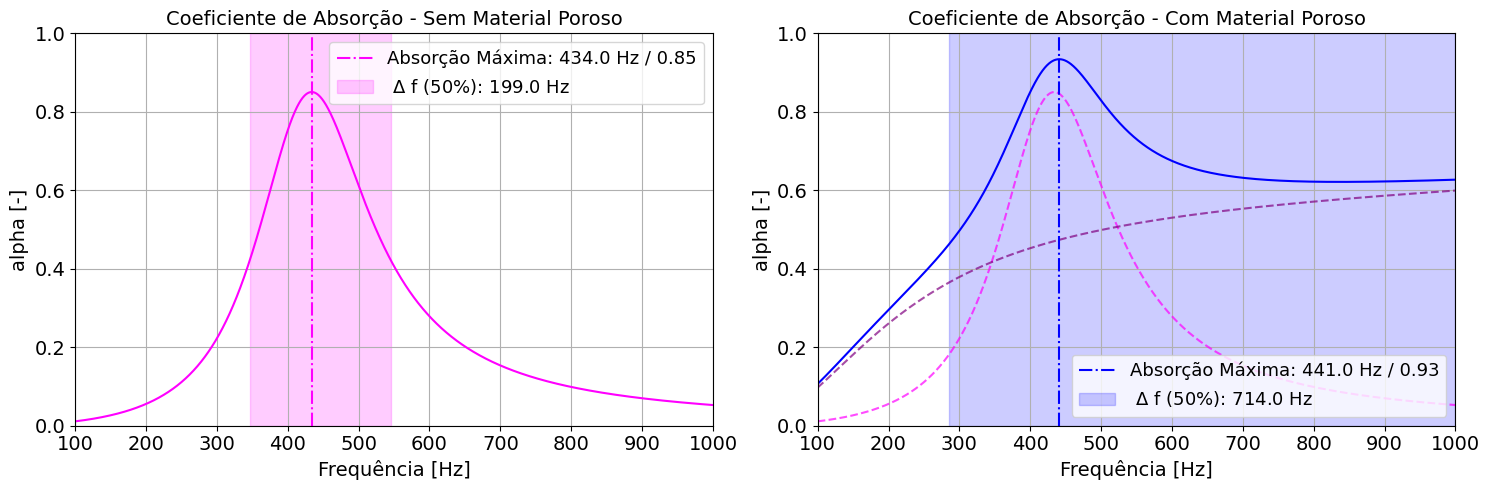

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(f, alpha_nohybrid, color='magenta')
ax1.tick_params(axis='both', which='major', labelsize=14)
freq_pico = df_indicators['Freq. de Pico'].iloc[0]
alpha_pico = df_indicators['Máx. Absorçao'].iloc[0]
f1 = df_indicators['Freq. 50%'].iloc[0][0]
f2 = df_indicators['Freq. 50%'].iloc[0][1]
ax1.axvline(x=freq_pico, color='magenta', linestyle='-.', label=f'Absorção Máxima: {freq_pico} Hz / {round(alpha_pico, 2)}')
ax1.axvspan(f1, f2, color='magenta', alpha=0.2, label=f' $\Delta$ f (50%): {f2-f1} Hz')
ax1.set_title('Coeficiente de Absorção - Sem Material Poroso', fontsize=14)
ax1.set_xlabel('Frequência [Hz]', fontsize=14)
ax1.set_ylabel('alpha [-]', fontsize=14)
ax1.set_xlim(100, 1000)
ax1.set_ylim(0, 1)
ax1.legend(fontsize=13)
ax1.grid(True)

ax2.plot(f, alpha_hybrid, color='blue')
ax2.plot(f, alpha_nohybrid, color='magenta', linestyle='--', alpha=0.7)
ax2.plot(f, alpha_porous, color='purple', linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=14)
freq_pico = df_indicators['Freq. de Pico'].iloc[1]
alpha_pico = df_indicators['Máx. Absorçao'].iloc[1]
f1 = df_indicators['Freq. 50%'].iloc[1][0]
f2 = f[-1]
ax2.axvline(x=freq_pico, color='blue', linestyle='-.', label=f'Absorção Máxima: {freq_pico} Hz / {round(alpha_pico, 2)}')
ax2.axvspan(f1, f2, color='blue', alpha=0.2, label=f' $\Delta$ f (50%): {f2-f1} Hz')
ax2.set_title('Coeficiente de Absorção - Com Material Poroso', fontsize=14)
ax2.set_xlabel('Frequência [Hz]', fontsize=14)
ax2.set_ylabel('alpha [-]', fontsize=14)
ax2.set_xlim(100, 1000)
ax2.set_ylim(0, 1)
ax2.legend(fontsize=13, loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()


### Parte b) Determinar, apresentar e discutir sobre o comportamento da impedância acústica total, e das partes Real e Imaginária, na faixa de frequência de 100 Hz até 1.000 Hz, em relação a: i) perfuração e cavidade; ii) material poroso, perfuração e cavidade. Qual é o efeito da adição do material absorvente?

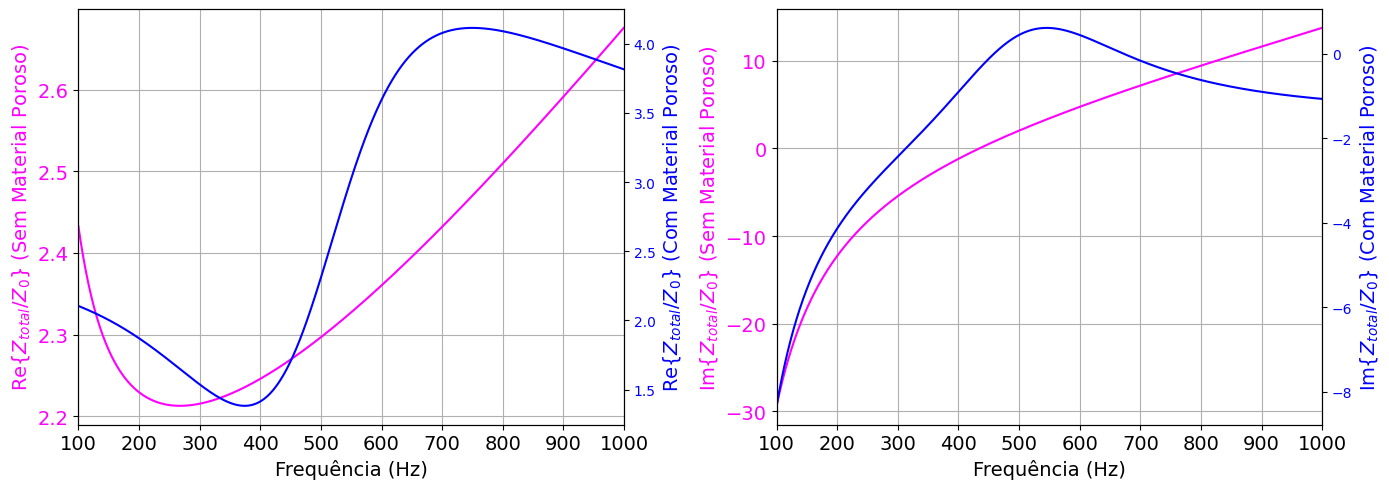

In [25]:
## Gráfico das Impedâncias Acústica Total
plt.figure(figsize=(14, 5))

# Parte Real - Impedância
ax1 = plt.subplot(1, 2, 1)
ax1.plot(f, np.real(Za_nohybrid / (rho0 * c0)), label='Sem Material Poroso', color='magenta')
ax1.set_xlabel('Frequência (Hz)', fontsize=14)
ax1.set_ylabel('Re{$Z_{total}$/$Z_0$} (Sem Material Poroso)', fontsize=14, color='magenta')
ax1.tick_params(axis='y', labelcolor='magenta')
ax1.set_xlim(100, 1000)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = ax1.twinx()
ax2.plot(f, np.real(Za_hybrid / (rho0 * c0)), label='Com Material Poroso', color='blue')
ax2.set_ylabel('Re{$Z_{total}$/$Z_0$} (Com Material Poroso)', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Parte Imaginária - Impedância
ax3 = plt.subplot(1, 2, 2)
ax3.plot(f, np.imag(Za_nohybrid / (rho0 * c0)), label='Sem Material Poroso', color='magenta')
ax3.set_xlabel('Frequência (Hz)', fontsize=14)
ax3.set_ylabel('Im{$Z_{total}$/$Z_0$} (Sem Material Poroso)', fontsize=14, color='magenta')
ax3.tick_params(axis='y', labelcolor='magenta')
ax3.set_xlim(100, 1000)
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=14)

ax4 = ax3.twinx()
ax4.plot(f, np.imag(Za_hybrid / (rho0 * c0)), label='Com Material Poroso', color='blue')
ax4.set_ylabel('Im{$Z_{total}$/$Z_0$} (Com Material Poroso)', fontsize=14, color='blue')
ax4.tick_params(axis='y', labelcolor='blue')

plt.tight_layout()
plt.show()

### Parte c) Realizar uma análise de sensibilidade dos parâmetros geométricos do MMA indicado para avaliar o coeficiente de absorção sonora (sem material absorvente): espessura do painel t; altura Lf e largura df (perfuração fenda); largura m e altura L da célula unitária; espessura h da cavidade dos espaços enrolados; espessura b das paredes internas; altura de seção transversal W; comprimento efetivo de propagação Leff. Considere uma variação (entre a metade e o dobro) do valor de cada parâmetro. Quais são os principais parâmetros que influenciam a absorção sonora? || Parte d) Apresentar e discutir sobre a tendência dos valores de absorção sonora pico e a largura de banda efetiva (50%) em função dos parâmetros geométricos;

In [28]:
all_results_sensibility = []

#### Espessura do Painel, t

In [29]:
##Parâmetro Discretizado
var = t
var_disc = np.linspace(t/2, t*2, 100)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=m,
      b=b,
      h=h,
      N=N,
      L=L,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=df,
      Lf=Lf,
      t=v,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)

all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

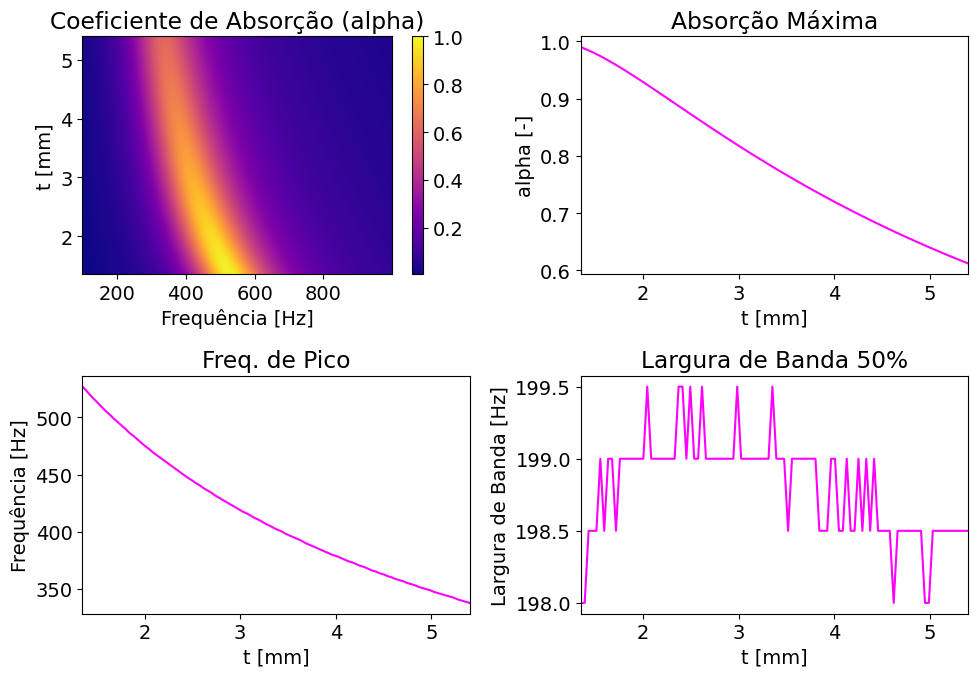

In [32]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min()*1e3, var_disc.max()*1e3], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('t [mm]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc*1e3, maxalpha, color='magenta')
plt.title('Absorção Máxima')
plt.xlabel('t [mm]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc*1e3, freq_maxalpha, color='magenta')
plt.title('Freq. de Pico')
plt.xlabel('t [mm]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc*1e3, deltaf50_alpha, color='magenta')
plt.title('Largura de Banda 50%')
plt.xlabel('t [mm]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

plt.tight_layout()
plt.show()

#### ALtura da Fenda, $L_f$

In [33]:
##Parâmetro Discretizado
var = Lf
var_disc = np.linspace(Lf/2, Lf*2, 100)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=m,
      b=b,
      h=h,
      N=N,
      L=L,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=df,
      Lf=v,
      t=t,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)

all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

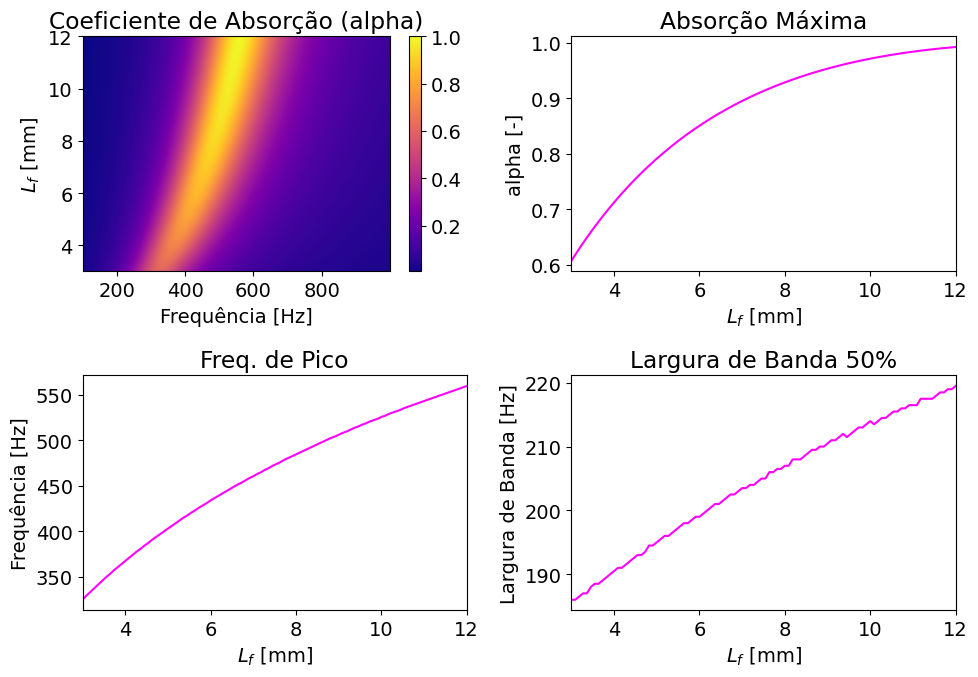

In [34]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min()*1e3, var_disc.max()*1e3], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('$L_f$ [mm]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc*1e3, maxalpha, color='magenta')
plt.title('Absorção Máxima')
plt.xlabel('$L_f$ [mm]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc*1e3, freq_maxalpha, color='magenta')
plt.title('Freq. de Pico')
plt.xlabel('$L_f$ [mm]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc*1e3, deltaf50_alpha, color='magenta')
plt.title('Largura de Banda 50%')
plt.xlabel('$L_f$ [mm]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

plt.tight_layout()
plt.show()

#### Largura da Fenda, $d_f$

In [35]:
##Parâmetro Discretizado
var = df
var_disc = np.linspace(df/2, df*2, 100)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=m,
      b=b,
      h=h,
      N=N,
      L=L,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=v,
      Lf=Lf,
      t=t,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)

all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

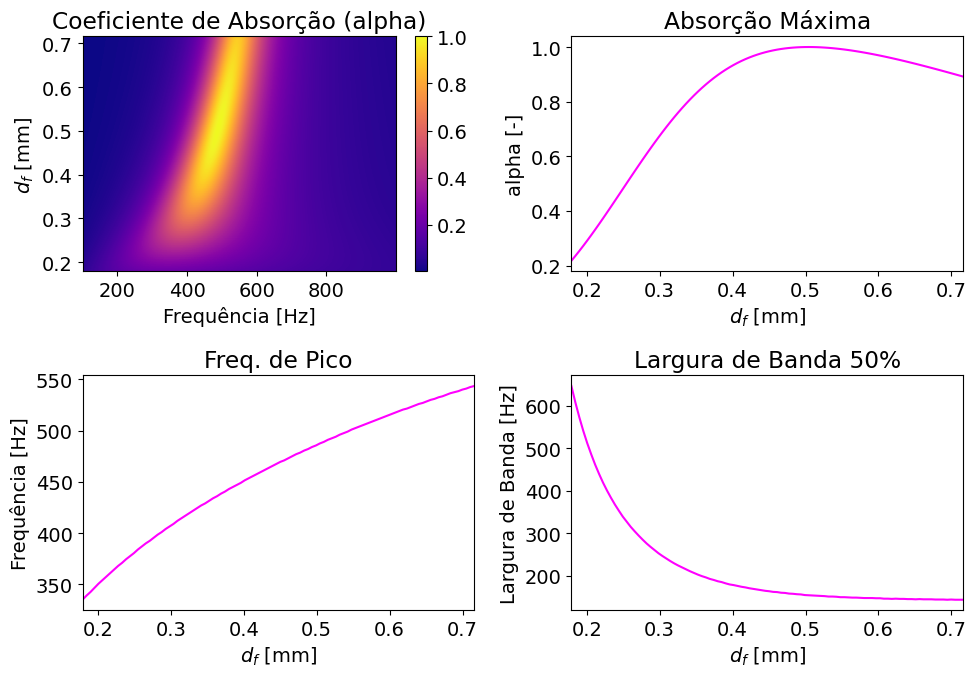

In [36]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min()*1e3, var_disc.max()*1e3], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('$d_f$ [mm]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc*1e3, maxalpha, color='magenta')
plt.title('Absorção Máxima')
plt.xlabel('$d_f$ [mm]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc*1e3, freq_maxalpha, color='magenta')
plt.title('Freq. de Pico')
plt.xlabel('$d_f$ [mm]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc*1e3, deltaf50_alpha, color='magenta')
plt.title('Largura de Banda 50%')
plt.xlabel('$d_f$ [mm]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

plt.tight_layout()
plt.show()

#### Largura da Célula Unitária, m

In [37]:
##Parâmetro Discretizado
var = m
var_disc = np.linspace(m/2, m*2, 100)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=v,
      b=b,
      h=h,
      N=N,
      L=L,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=df,
      Lf=Lf,
      t=t,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)
all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

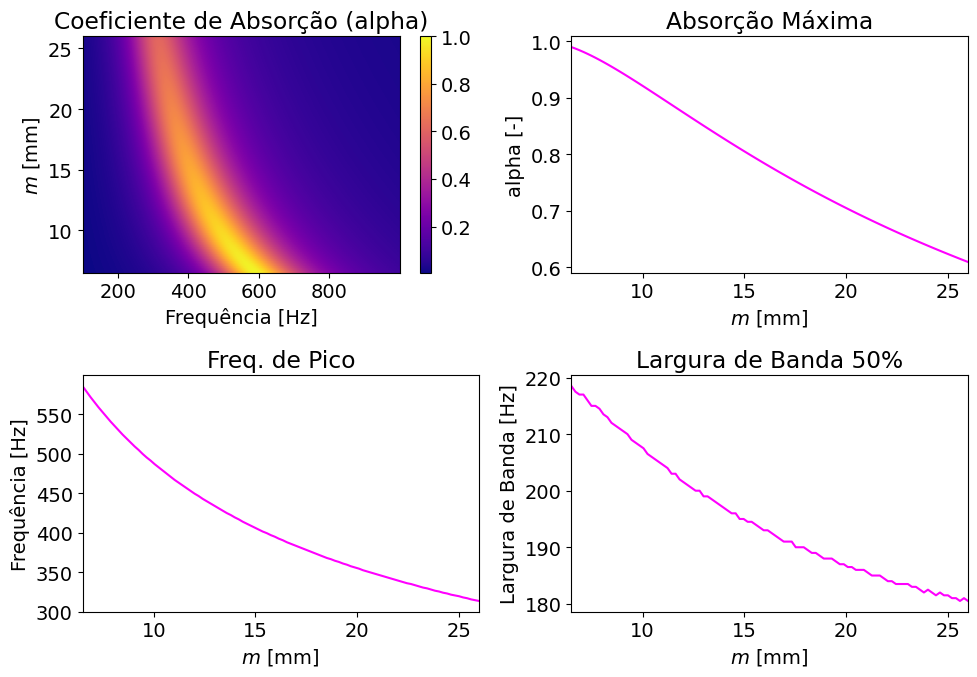

In [38]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min()*1e3, var_disc.max()*1e3], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('$m$ [mm]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc*1e3, maxalpha, color='magenta')
plt.title('Absorção Máxima')
plt.xlabel('$m$ [mm]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc*1e3, freq_maxalpha, color='magenta')
plt.title('Freq. de Pico')
plt.xlabel('$m$ [mm]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc*1e3, deltaf50_alpha, color='magenta')
plt.title('Largura de Banda 50%')
plt.xlabel('$m$ [mm]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

plt.tight_layout()
plt.show()

#### Altura da Célula Unitária, L

In [39]:
##Parâmetro Discretizado
var = L
var_disc = np.linspace(L/2, L*2, 100)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=m,
      b=b,
      h=h,
      N=N,
      L=v,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=df,
      Lf=Lf,
      t=t,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)
all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

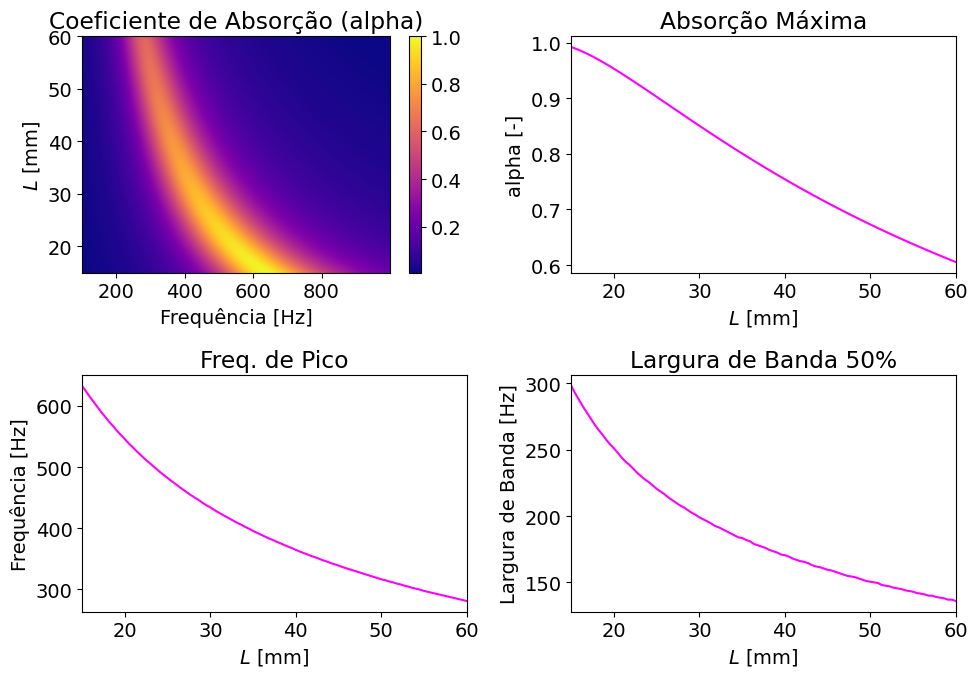

In [40]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min()*1e3, var_disc.max()*1e3], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('$L$ [mm]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc*1e3, maxalpha, color='magenta')
plt.title('Absorção Máxima')
plt.xlabel('$L$ [mm]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc*1e3, freq_maxalpha, color='magenta')
plt.title('Freq. de Pico')
plt.xlabel('$L$ [mm]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc*1e3, deltaf50_alpha, color='magenta')
plt.title('Largura de Banda 50%')
plt.xlabel('$L$ [mm]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

plt.tight_layout()
plt.show()

#### Espessura da Cavidade, h

In [41]:
##Parâmetro Discretizado
var = h
var_disc = np.linspace(h/2, h*2, 100)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=m,
      b=b,
      h=v,
      N=N,
      L=L,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=df,
      Lf=Lf,
      t=t,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)
all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

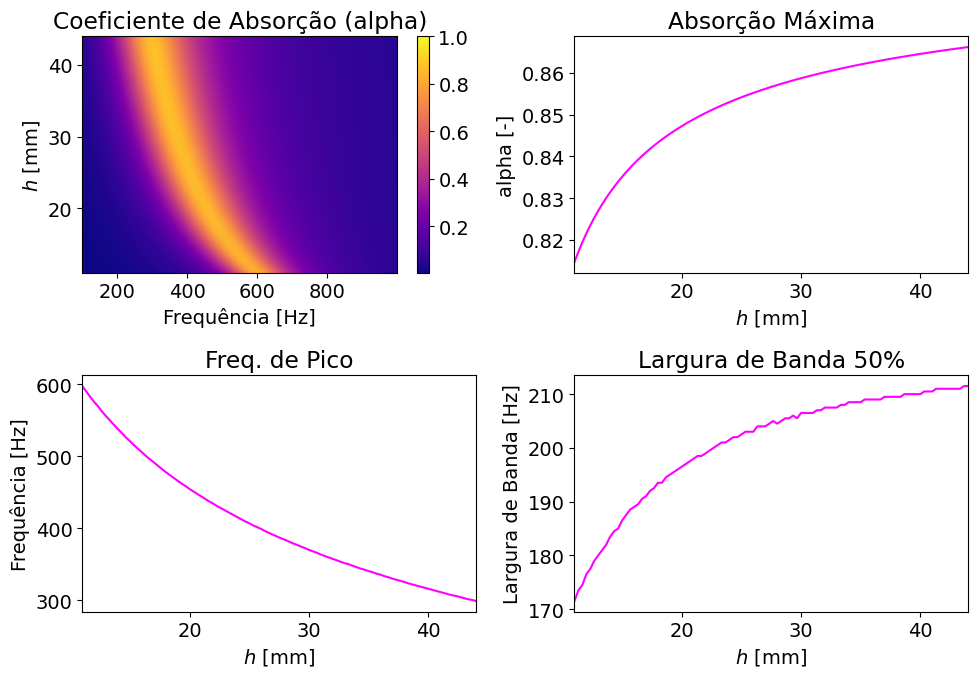

In [42]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min()*1e3, var_disc.max()*1e3], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('$h$ [mm]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc*1e3, maxalpha, color='magenta')
plt.title('Absorção Máxima')
plt.xlabel('$h$ [mm]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc*1e3, freq_maxalpha, color='magenta')
plt.title('Freq. de Pico')
plt.xlabel('$h$ [mm]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc*1e3, deltaf50_alpha, color='magenta')
plt.title('Largura de Banda 50%')
plt.xlabel('$h$ [mm]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

plt.tight_layout()
plt.show()

#### Espessuras das Paredes Internas, b

In [43]:
##Parâmetro Discretizado
var = b
var_disc = np.linspace(b/2, b*2, 100)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=m,
      b=v,
      h=h,
      N=N,
      L=L,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=df,
      Lf=Lf,
      t=t,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)
all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

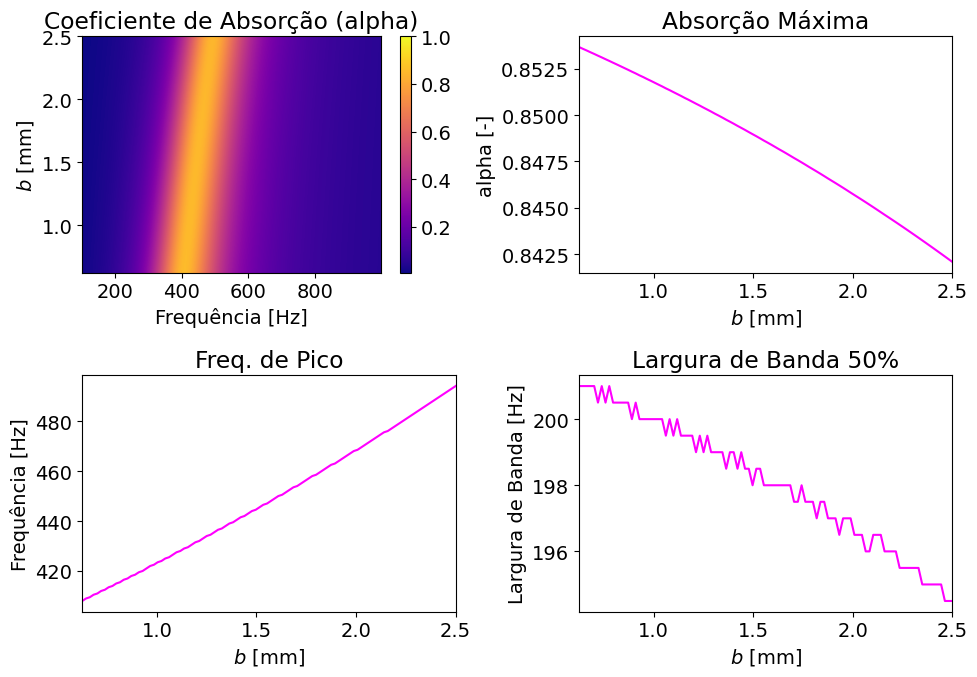

In [44]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min()*1e3, var_disc.max()*1e3], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('$b$ [mm]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc*1e3, maxalpha, color='magenta')
plt.title('Absorção Máxima')
plt.xlabel('$b$ [mm]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc*1e3, freq_maxalpha, color='magenta')
plt.title('Freq. de Pico')
plt.xlabel('$b$ [mm]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc*1e3, deltaf50_alpha, color='magenta')
plt.title('Largura de Banda 50%')
plt.xlabel('$b$ [mm]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min()*1e3, var_disc.max()*1e3)

plt.tight_layout()
plt.show()

#### Número de Espaços Enrolados, N

In [45]:
##Parâmetro Discretizado
var_disc = np.arange(2,7,1)
##Cálculo do Comportamente de Absorção
alpha_var = np.zeros((len(var_disc), len(f)))
maxalpha = []
freq_maxalpha = []
deltaf50_alpha = []
for i, v in enumerate(var_disc):
  ## Calculo da Impedancia do MMA Com/Sem Material Poroso
  _, Z_i = calc_finalimpedance(
      f=f,
      m=m,
      b=b,
      h=h,
      N=v,
      L=L,
      rho0=rho0,
      eta=eta,
      P0=P0,
      gamma=gamma,
      kappa=kappa,
      Cv=Cv,
      df=df,
      Lf=Lf,
      t=t,
      alphainf=alphainf,
      sigma=sigma,
      phi=phi,
      Lambda=Lambda,
      Lambdalinha=Lambdalinha,
      Pr=Pr,
      e=e,
  )
  ## Calculo do Coeficiente de Absorção
  alpha_i = calc_absorptioncoefficient(
      Z_i,
      rho0*c0
  )
  alpha_var[i] = alpha_i
  ## Calculo dos Indicadores de Absorção
  max_value, freq_max_value, _, _, deltaf50, _, _, _ = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h+t
  )
  maxalpha.append(max_value)
  freq_maxalpha.append(freq_max_value)
  deltaf50_alpha.append(deltaf50)
all_results_sensibility.append([alpha_var, maxalpha, freq_maxalpha, deltaf50_alpha])

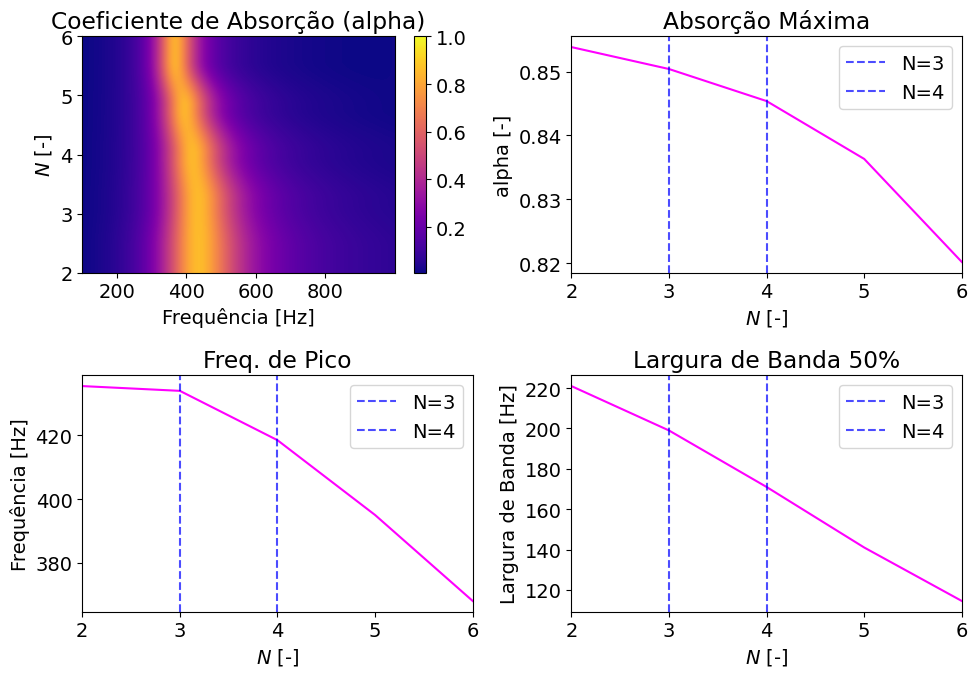

In [47]:
# Gráfico de Sensibilidade
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
plt.imshow(alpha_var, extent=[f.min(), f.max(), var_disc.min(), var_disc.max()], origin='lower', cmap='plasma', aspect='auto', vmax=1)
plt.colorbar()
plt.title('Coeficiente de Absorção (alpha)')
plt.ylabel('$N$ [-]')
plt.xlabel('Frequência [Hz]')

# Tendência dos Indicadores - Absorção Máxima
plt.subplot(2, 2, 2)
plt.plot(var_disc, maxalpha, color='magenta')
plt.axvline(3, linestyle='--', color='blue', label='N=3', alpha=0.7)
plt.axvline(4, linestyle='--', color='blue', label='N=4', alpha=0.7)
plt.title('Absorção Máxima')
plt.xlabel('$N$ [-]')
plt.ylabel('alpha [-]')
plt.xlim(var_disc.min(), var_disc.max())
plt.legend(loc='upper right')

# Tendência dos Indicadores - Freq. de Pico
plt.subplot(2, 2, 3)
plt.plot(var_disc, freq_maxalpha, color='magenta')
plt.axvline(3, linestyle='--', color='blue', label='N=3', alpha=0.7)
plt.axvline(4, linestyle='--', color='blue', label='N=4', alpha=0.7)
plt.title('Freq. de Pico')
plt.xlabel('$N$ [-]')
plt.ylabel('Frequência [Hz]')
plt.xlim(var_disc.min(), var_disc.max())
plt.legend(loc='upper right')

# Tendência dos Indicadores - Largura de Banda 50%
plt.subplot(2, 2, 4)
plt.plot(var_disc, deltaf50_alpha, color='magenta')
plt.axvline(3, linestyle='--', color='blue', label='N=3', alpha=0.7)
plt.axvline(4, linestyle='--', color='blue', label='N=4', alpha=0.7)
plt.title('Largura de Banda 50%')
plt.xlabel('$N$ [-]')
plt.ylabel('Largura de Banda [Hz]')
plt.xlim(var_disc.min(), var_disc.max())
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Parte f) Avalie e discuta sobre o comportamento do coeficiente de absorção sonora de um MMA acoplado com N = 3 e 4 espaços enrolados, sem material absorvente.

In [48]:
## Calculo da Impedancia do MMA Sem Material Poroso - N=3 e N=4
_, Z_n3 = calc_finalimpedance(
                            f=f,
                            m=m,
                            b=b,
                            h=h,
                            N=3,
                            L=L,
                            rho0=rho0,
                            eta=eta,
                            P0=P0,
                            gamma=gamma,
                            kappa=kappa,
                            Cv=Cv,
                            df=df,
                            Lf=Lf,
                            t=t,
                            alphainf=alphainf,
                            sigma=sigma,
                            phi=phi,
                            Lambda=Lambda,
                            Lambdalinha=Lambdalinha,
                            Pr=Pr,
                            e=e,
                        )
_, Z_n4 = calc_finalimpedance(
                            f=f,
                            m=m,
                            b=b,
                            h=h,
                            N=4,
                            L=L,
                            rho0=rho0,
                            eta=eta,
                            P0=P0,
                            gamma=gamma,
                            kappa=kappa,
                            Cv=Cv,
                            df=df,
                            Lf=Lf,
                            t=t,
                            alphainf=alphainf,
                            sigma=sigma,
                            phi=phi,
                            Lambda=Lambda,
                            Lambdalinha=Lambdalinha,
                            Pr=Pr,
                            e=e,
                        )
## Calculo do Coeficiente de Absorção
alpha_n3= calc_absorptioncoefficient(
    Z_n3,
    rho0*c0
)
alpha_n4 = calc_absorptioncoefficient(
    Z_n4,
    rho0*c0
)

In [49]:
## Cálculo dos Indicadores
alpha_all = [alpha_n3, alpha_n4]
h_all = [h+t, h+t]
indicators={
    'Sistema': ['N=3', 'N=4'],
    'Máx. Absorçao': [],
    'Freq. de Pico': [],
    'Freq. 50%':[],
    'Largura de Banda 50%': [],
    'Largura de Banda Relativa': [],
    'E': [],
    'E^-1': []
}
for i, alpha_i in enumerate(alpha_all):
  max_value, freq_max_value, freq_half_max_1, freq_half_max_2, deltaf50, deltaf50_rel, E, E_inv = calc_indicators(
      alpha=alpha_i,
      f=f,
      c0=c0,
      h=h_all[i]
  )
  indicators['Máx. Absorçao'].append(max_value)
  indicators['Freq. de Pico'].append(freq_max_value)
  indicators['Freq. 50%'].append([freq_half_max_1,freq_half_max_2])
  indicators['Largura de Banda 50%'].append(deltaf50)
  indicators['Largura de Banda Relativa'].append(deltaf50_rel)
  indicators['E'].append(E)
  indicators['E^-1'].append(E_inv)
df_indicators = pd.DataFrame(indicators)
df_indicators

,Sistema,Máx. Absorçao,Freq. de Pico,Freq. 50%,Largura de Banda 50%,Largura de Banda Relativa,E,E^-1
0,N=3,0.850403,434.0,"[346.5, 545.5]",199.0,0.458525,0.031253,31.996866
1,N=4,0.845377,418.5,"[341.5, 512.5]",171.0,0.408602,0.030137,33.181935


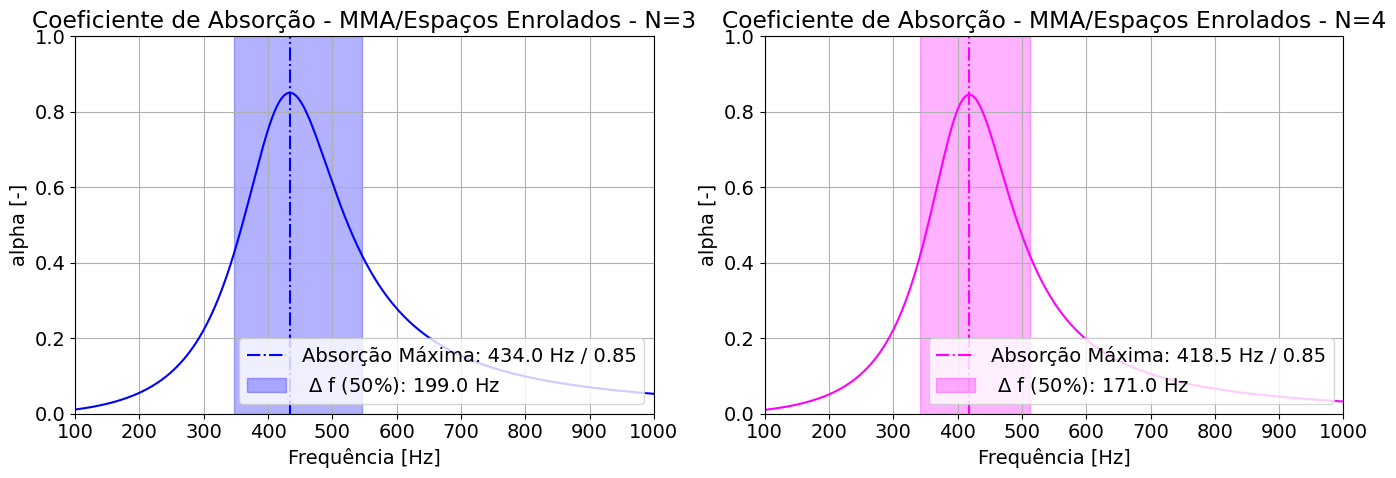

In [51]:
plt.rcParams.update({'font.size': 14})
##Gráfico dos Coeficentes de Absorção
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(f, alpha_n3, color='blue')
freq_pico=df_indicators['Freq. de Pico'].iloc[0]
alpha_pico=df_indicators['Máx. Absorçao'].iloc[0]
f1=df_indicators['Freq. 50%'].iloc[0][0]
f2=df_indicators['Freq. 50%'].iloc[0][1]
ax1.axvline(x=freq_pico, color='blue', linestyle='-.', label=f'Absorção Máxima: {freq_pico} Hz / {round(alpha_pico,2)}')
ax1.axvspan(f1, f2, color='blue', alpha=0.3, label=f' $\Delta$ f (50%): {f2-f1} Hz')
ax1.set_title('Coeficiente de Absorção - MMA/Espaços Enrolados - N=3')
ax1.set_xlabel('Frequência [Hz]')
ax1.set_ylabel('alpha [-]')
ax1.set_xlim(100, 1000)
ax1.set_ylim(0, 1)
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(f, alpha_n4, color='magenta')
freq_pico=df_indicators['Freq. de Pico'].iloc[1]
alpha_pico=df_indicators['Máx. Absorçao'].iloc[1]
f1=df_indicators['Freq. 50%'].iloc[1][0]
f2=df_indicators['Freq. 50%'].iloc[1][1]
ax2.axvline(x=freq_pico, color='magenta', linestyle='-.', label=f'Absorção Máxima: {freq_pico} Hz / {round(alpha_pico,2)}')
ax2.axvspan(f1, f2, color='magenta', alpha=0.3, label=f' $\Delta$ f (50%): {f2-f1} Hz')
ax2.set_title('Coeficiente de Absorção - MMA/Espaços Enrolados - N=4')
ax2.set_xlabel('Frequência [Hz]')
ax2.set_ylabel('alpha [-]')
ax2.set_xlim(100, 1000)
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()